# **Programming for Data Analysis**
---

**Author: Damien Farrell**

---

## Project 1:
## Simulation of House Prices in Ireland

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import httpx
from selectolax.parser import HTMLParser
import time

In [2]:
# Set seed for reproducibility
np.random.seed(10)

# Number of samples
num_samples = 500

### **Introduction**
For this data analytics project, I have chosen to simulate a dataset related to house prices in Ireland.

**Variables**

1. House Price
1. House Size
1. Number of Bedrooms
1. Location

### **House Price:**

The dependent variable representing the market value of a house. This will be a continuous variable with a positive real number format.

**Data Generation**

Simulate house prices using a normal distribution. Research on local housing markets can provide insights into the mean and standard deviation for generating realistic price data.

Maybe log normal distributed is better.

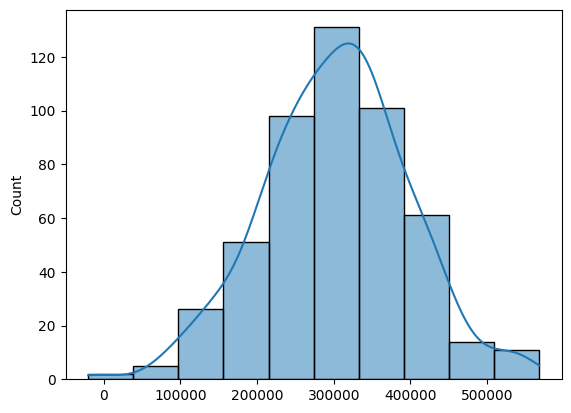

In [3]:
min_price = 0

mean_price = 300000
std_dev_price = 100000

house_prices = np.random.normal(mean_price, std_dev_price, num_samples)

sns.histplot(house_prices, kde=True, bins=10);

### **House Size:**

The size of the house in meters squared. This will be a positive real floating point number.

**Data Generation**


Simulate house size using a normal distribution.

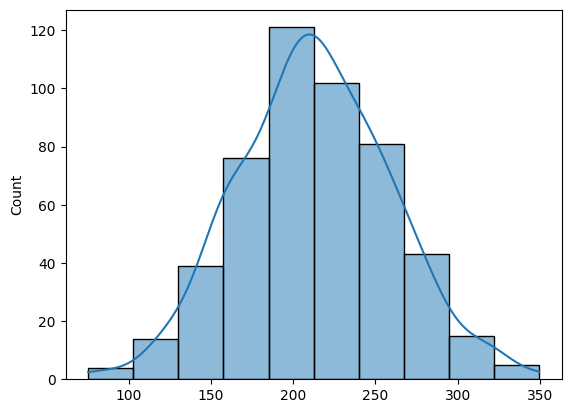

In [4]:
mean_house_size_m2 = 216
std_dev_house_size_m2 = 50

house_size = np.random.normal(mean_house_size_m2, std_dev_house_size_m2, num_samples)

sns.histplot(house_size, kde=True, bins=10);

#### **Number of Bedrooms:**

The count of bedrooms in a house. This will be a positive integer.

**Data Generation**

Simulate the number of bedrooms using a discrete distribution. Research on typical bedroom counts in houses can guide the distribution.

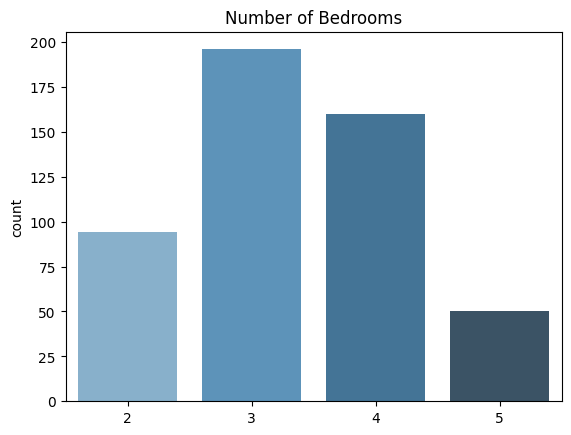

In [5]:
bedroom_count = np.random.choice([2, 3, 4, 5], size=num_samples, p=[0.2, 0.4, 0.3, 0.1])

sns.countplot(x=bedroom_count, palette='Blues_d')
plt.title('Number of Bedrooms');

### **Location**

Geographic variable representing the location of the house.

**Data Generation**

?

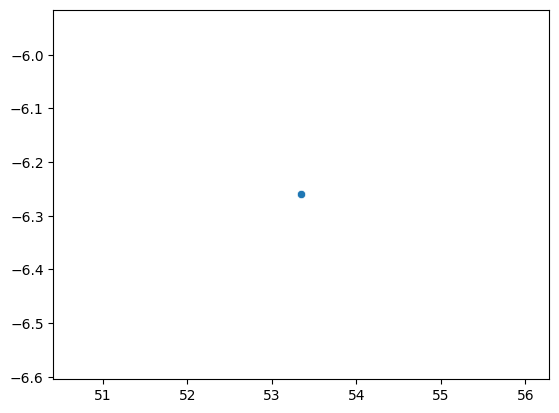

In [6]:
latitude = 53.3498
longitude = -6.2603

sns.scatterplot(x=[latitude],y=[longitude]);

In [7]:
# Create DataFrame
house_data = pd.DataFrame({
    'House_Price': house_prices.round(2),
    'House_Size': house_size.round(2),
    'Bedrooms': bedroom_count,
})

house_data.head()

,House_Price,House_Size,Bedrooms
0,433158.65,287.96,3
1,371527.90,285.11,4
2,145459.97,262.07,4
3,299161.62,187.36,3
4,362133.60,279.75,4


Real property data is hard to come by so I decided to scrape Daft. I needed to figure out the average floor area of a house and the minimum house price somehow etc. CSO only gives simulated data.


In [57]:
def get_html(baseurl, page):
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:120.0) Gecko/20100101 Firefox/120.0"}
    resp = httpx.get(baseurl + str((page*20)-20), headers=headers)
    resp.raise_for_status()
    try:
        resp.raise_for_status()
    except httpx.HTTPStatusError as exc:
        print(f"Error response {exc.response.status_code} while requesting {exc.request.url!r}. Page Limit Exceeded")
        return False # Returns False when it exceeds the last webpage in order to stop the loop.
    html = HTMLParser(resp.text)
    return html

def extract_text(html, sel):
    try:
        text = html.css_first(sel).text(strip=True)
        return clean_data(text)
    except AttributeError:
        return None

def parse_page(html):
    card_elements = html.css("div[data-testid='card-body']")

    for card_element in card_elements:
        property_info = {
            "Address": extract_text(card_element, "[data-testid='address']"),
            "Price": extract_text(card_element, "[data-testid='price']"),
            "Bedrooms": extract_text(card_element, "[data-testid='beds']"),
            "Bathrooms": extract_text(card_element, "[data-testid='baths']"),
            "Floor Area": extract_text(card_element, "[data-testid='floor-area']"),
            "Property Type": extract_text(card_element, "[data-testid='property-type']")
        }
        yield property_info

def clean_data(value):
    chars_to_remove = ["€", "m²", "Bed", "Bath", "ONLINE OFFERS", "ONLINE OFFER", "AMV:"]
    for char in chars_to_remove:
        if char in value:
            value = value.replace(char, "")
    return value.strip()

def daft_scraper():
    baseurl = "https://www.daft.ie/property-for-sale/ireland?pageSize=20&from="
    df_list = []
    num_of_pages_to_scrape = 3
    
    for x in range(1,num_of_pages_to_scrape):
        print(f"Gathering Page: {x}")
        html = get_html(baseurl, x)
        if html is False:
            break
        data = parse_page(html)

        for item in data:
            df_list.append(item)
            
        time.sleep(0.1)

    df = pd.DataFrame(df_list)

    return df

In [178]:
scraped_df = daft_scraper()

Gathering Page: 1
Gathering Page: 2


In [179]:
scraped_df["Price"] = pd.to_numeric(scraped_df["Price"].str.replace(",", ""), errors="coerce")
scraped_df["Bedrooms"] = pd.to_numeric(scraped_df["Bedrooms"], errors="coerce")
scraped_df["Bathrooms"] = pd.to_numeric(scraped_df["Bathrooms"], errors="coerce")
scraped_df["Floor Area"] = pd.to_numeric(scraped_df["Floor Area"], errors="coerce")

In [180]:
scraped_df

,Address,Price,Bedrooms,Bathrooms,Floor Area,Property Type
0,"Mellenton House, Carlow Town, Co. Carlow, R93R796",525000.0,6.0,3.0,230.0,Detached
1,"16 The Gates, Matthew Hill, Lehenaghmore, Co. ...",675000.0,5.0,3.0,204.0,Detached
2,"Apartment 10, South Quay, The Maltings, Midlet...",235000.0,2.0,2.0,82.0,Townhouse
3,"Apartment 2, Ryston View, Newbridge, Co. Kilda...",300000.0,2.0,2.0,75.0,Apartment
4,"12 Croghtamore Gardens, Pouladuff Road, Poulad...",295000.0,3.0,2.0,85.0,Semi-D
5,"67 Douglas Street, Cork City, Co. Cork, T12N510",350000.0,3.0,2.0,111.0,Terrace
6,"Site with Full Planning Permission, Blackberry...",550000.0,NaN,NaN,NaN,Site
7,"Killough Castle, Killough, Thurles, Co. Tipper...",5500000.0,6.0,2.0,555.0,Detached
8,"Tullycommons, Castlebar, Co. Mayo, F23A371",675000.0,4.0,5.0,255.0,Detached
9,"15 Connolly Street, Bandon, Co. Cork, P72TF25",250000.0,3.0,1.0,85.0,Terrace


In [181]:
df = pd.DataFrame()
df["Price"] = scraped_df["Price"].fillna(0).astype(int)
df["Bedrooms"] = scraped_df["Bedrooms"].fillna(0).astype(int)
df["Floor Area"] = scraped_df["Floor Area"].fillna(0).astype(int)
df["Property Type"] = scraped_df["Property Type"].astype("category")
df["Eircode"] = scraped_df["Address"].str.rsplit(',', n=1).str[-1]
df["Eircode"] = df["Eircode"].str[:4]

df = df[(df["Price"] != 0) & (df["Bedrooms"] != 0) & (df["Floor Area"] != 0) & (df["Property Type"] != "Site")]
df.reset_index(drop=True, inplace=True)

In [182]:
df.dtypes

Price               int32
Bedrooms            int32
Floor Area          int32
Property Type    category
Eircode            object
dtype: object

In [183]:
df

,Price,Bedrooms,Floor Area,Property Type,Eircode
0,525000,6,230,Detached,R93
1,675000,5,204,Detached,T12
2,235000,2,82,Townhouse,P25
3,300000,2,75,Apartment,W12
4,295000,3,85,Semi-D,T12
5,350000,3,111,Terrace,T12
6,5500000,6,555,Detached,E41
7,675000,4,255,Detached,F23
8,250000,3,85,Terrace,P72
9,950000,4,192,Detached,W91


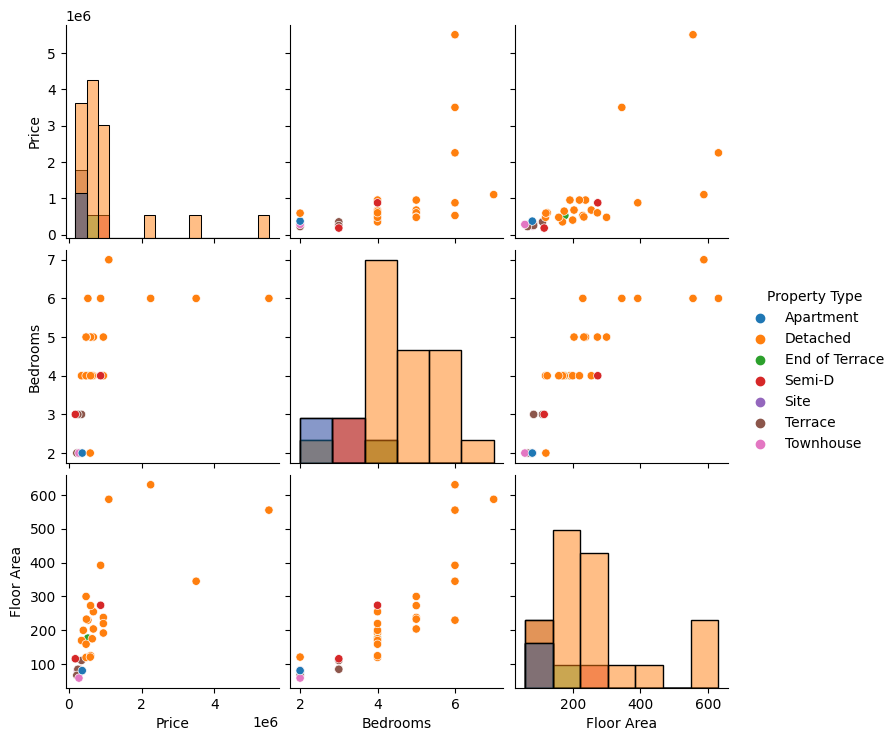

In [185]:
sns.pairplot(df, hue="Property Type", diag_kind='hist');

### **Relationships**

**Correlation between House Price and House Size:**

Simulate a positive correlation between house price and house size, as larger houses generally tend to have higher prices.

**Influence of Number of Bedrooms:**

Simulate an influence of the number of bedrooms on house price. Larger houses with more bedrooms should have higher prices.

**Geographic Location Impact:**

Introduce a relationship between geographic location and house price. Certain geographic areas may positively or negatively influence house prices.


https://www.spcforexcel.com/knowledge/basic-statistics/deciding-which-distribution-fits-your-data-best/


https://statisticsbyjim.com/hypothesis-testing/identify-distribution-data/
https://statisticsbyjim.com/basics/goodness-of-fit/
https://statisticsbyjim.com/basics/skewed-distribution/

https://docs.scipy.org/doc/scipy/reference/stats.html

Note that this example covers continuous data. For categorical and discrete variables, you should use the chi-square goodness of fit test.

https://statisticsbyjim.com/hypothesis-testing/chi-square-goodness-of-fit-test/



https://archive.ph/20230811082152/https://towardsdatascience.com/how-to-find-the-best-theoretical-distribution-for-your-data-a26e5673b4bd#selection-643.182-653.170

https://www.datacamp.com/tutorial/probability-distributions-python

https://www.analyticsvidhya.com/blog/2021/09/q-q-plot-ensure-your-ml-model-is-based-on-the-right-distributions/https://archive.ph/20221125141253/https://towardsdatascience.com/understand-q-q-plot-using-simple-python-4f83d5b89f8f#selection-965.3-979.30

https://numpy.org/doc/1.16/reference/routines.random.html

https://stackoverflow.com/questions/45579525/returning-a-dataframe-in-python-function

https://www.geeksforgeeks.org/multi-plot-grid-in-seaborn/


https://stackoverflow.com/questions/6871201/plot-two-histograms-on-single-chart


https://stackoverflow.com/questions/69141790/seaborn-reg-plots-with-the-same-y-axis-scale-side-by-side


Right Skewed. The mean overestimates the most common values in a positively skewed distribution.

Using a QQ Plot to determine if the dristribution follows a probability distribution...?

https://docs.scipy.org/doc/scipy/tutorial/stats/continuous_gumbel_l.html


https://www.statista.com/statistics/1417857/ireland-mean-new-home-size/

https://ec.europa.eu/eurostat/cache/digpub/housing/bloc-1b.html?lang=en

https://www.cso.ie/en/interactivezone/syntheticdata/housepricesyntheticdataset/

https://en.wikipedia.org/wiki/Parametric_statistics

https://www.youtube.com/@JohnWatsonRooney/videos

https://www.youtube.com/watch?v=1PCWwK0AsE0
https://www.youtube.com/watch?v=ZgVus_rmDBQ

https://visual.cso.ie/?body=entity/rppi

https://stackoverflow.com/questions/51607400/how-to-extract-first-8-characters-from-a-string-in-pandas

***Add more references and sort them out.***

***
# End